# Auditing process for protein-protein interaction (PPI) prediction applications

## Protein-protein interaction predicition scope


Park and Marcotte (2012) demonstrated that PPI predictors act differently when a protein has examples of its PPIs in the training set. They distinguished between three scenarios for testing whether a protein pair (A, B) interact:  
C1: Both protein A and B have examples of their other PPIs in the training data.   
C2: Only A or B has examples of its other PPIs in the training data.  
C3: Neither A nor B has examples of their PPIs in the training data.  
We call C2 and C3 **out-of-network** prediction, referring to the fact that at least one of the two proteins does not belong to the training PPI network, and we refer to C1 as **in-network** prediction. 
  
**Park and Marcotte found that PPI predictors perform near-random in the out-of-network prediction case. Throughout this study, all assessments are performed on the in-network prediction case.** 


In [55]:
# Initializations 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat

## [STEP 1]: Benchmarking 
The first step is to examine the performance of the PPI predictors on different datasets (trained on a subset and tested on another subset of the same dataset) to provide baseline performance for subsequent comparisons and to capture any framework-specific or dataset-specific performance patterns. 

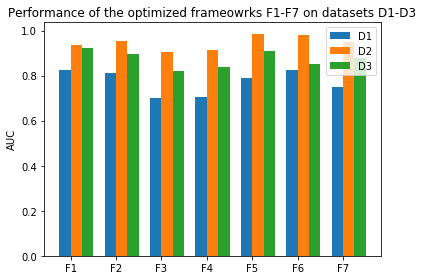

In [57]:
df1 = pd.read_csv('./DataForJupyters/BenchmarkingResults.csv')

labels = ['F1', 'F2', 'F3', 'F4', 'F5','F6','F7']
D1 = df1.D1
D2 = df1.D2
D3 = df1.D3

x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - (width/2), D1, width, label='D1')
rects2 = ax.bar(x + (width/2), D2, width, label='D2')
rects3 = ax.bar(x + 3*(width/2), D3, width, label='D3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('Performance of the optimized frameowrks F1-F7 on datasets D1-D3')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


We easily observe a ceiling performance for each dataset and that all predictors trained on D2 perform close to optimal. Such dataset-dependent performance can be attributed to data quality or it can be due to data-specific biases; we need to audit the predictors to figure this out.  

## [STEP 2]: *Generalizability Auditor I*
We next need to examine how well the predictors generalize to independent datasets. We used dataset D3 as the independent test dataset, yet in the in-network mode, meaning that each test example (A, B) in a testing subset from D3 has examples for PPIs of A and PPIs of B in the corresponding training set (from D1 and D2). If the models are learning correctly, their in-network performance should generalize, i.e., 
there should be no much performance deviation from that in benchmarking. 

The performances shown below are for 1) hold-out in-network test subsets from the training dataset (D1 or D2) that do not overlap with the training sets used for learning, and 2) in-network test subsets from the independent dataset (D3).  


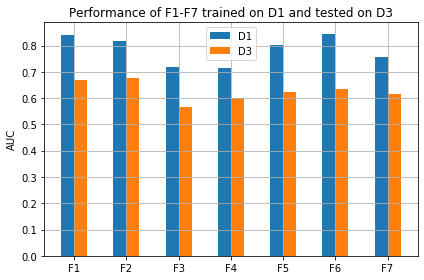

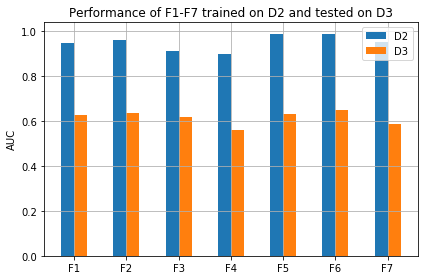

In [58]:
df2 = pd.read_csv('./DataForJupyters/GeneralizabilityIResults.csv')

# Setting up figures 
fig, axs = plt.subplots()
x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars
labels = ['F1', 'F2', 'F3', 'F4', 'F5','F6','F7']

# Marcotte dataset
D1cv = df2.D1cv
D1ts = df2.D1ts
rects1 = axs.bar(x - (width/2), D1cv, width, label='D1')
rects2 = axs.bar(x + (width/2), D1ts, width, label='D3')
axs.set_ylabel('AUC')
axs.set_title('Performance of F1-F7 trained on D1 and tested on D3')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Pan dataset
fig, axs = plt.subplots()
D2cv = df2.D2cv
D2ts = df2.D2ts
rects1 = axs.bar(x - (width/2), D2cv, width, label='D2')
rects2 = axs.bar(x + (width/2), D2ts, width, label='D3')
axs.set_ylabel('AUC')
axs.set_title('Performance of F1-F7 trained on D2 and tested on D3')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)

# Show figures 
fig.tight_layout()
plt.show()



A significant gap in performance is observed, especially for D2 that already performs near-optimal when training and testing are sampled from the same network.  
This is particularly puzzling since the testing examples, although sampled from a different PPI network (D3), are still in-network examples w.r.t each training set. This undoubtedly points to a strong bias in how the frameworks learn, requiring further investigation to figure out the bias source. 

## [STEP 3]: *Feature Auditor* 
We hypothesized that all frameworks are experiencing a similar bias causing their non-generalizability. There can be 1) a data-specific bias that no framework accounted for, or 2) a similarly behaving component in all framework that introduces a bias in handling the training data. 

We wanted to first make sure the frameworks are learning as intended from the input protein features. To test this hypothesis, we designed the *Feature Auditor* where the auxiliary model is similar to the main model except that for the input data, the protein features are replaced by random numbers, i.e. each protein is represented by the features of a random amino acid sequence. If the models are truly learning from protein features as intended, the performance of the auxiliary models should be near random (i.e. AUC ~ 0.5). 

We implemented four different randomization methods as described below:
R1: Features are extracted from random sequences of lengths equal to the original proteins. For example, if protein A amino acid sequence is 'AKLRSTVNEQ', it gets replaced by some random sequence like 'EQSAHKDSV' before extracting the features. 
R2: Features are extracted from a random sequence of a fixed length. We first decide on the fixed-length sequence, say the average length of all sequences in the training dataset. For protein A above, it is replaced by another random sequence of that new length, which is not necessarily equal to its original length. 
R3: Random numbers in the range of feature values. For protein A, for each feature, we select a random number within the range of that feature to replace the original feature value for A. For example, if A is represented by the feature vector [1, 0.1, 5, 8.2], and the range of the features are [1,5], [0,1], [0,10], and [5,20], respectively, a valid randomized feature vector for A can be [3, 0.5, 0, 17.3].
 R4: Shuffling each feature vector. In this scheme, the feature vector extracted for each protein is shuffled to produce the new randomized feature vector representing each protein throughout an experiment. For example, if protein A is represented by the feature vector [1, 0.1, 5, 8.2], a valid randomized feature vector under this scheme can be [1, 8.2, 5, 0.1].

The performances for the four randomization schemes are very similar for the examined testing case. We are using the result of Method R2 below and the results of Method R3 for F6 where feature generation is extremely computationally expensive (cannot reproduce R2 features in a timely manner), and for F7, where running hundreds of experiments was computationally expensive as well. 


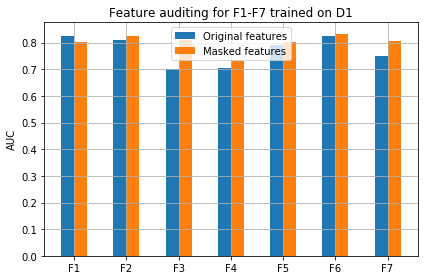

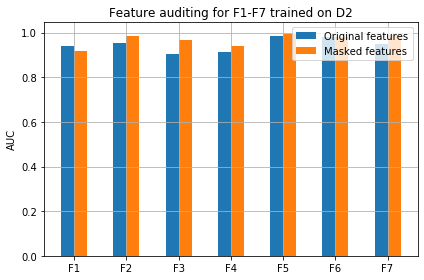

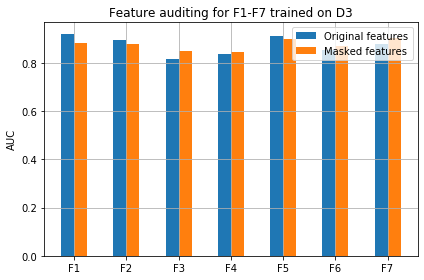

In [60]:
df3 = pd.read_csv('./DataForJupyters/FeatureAuditorResults.csv')

# Setting up figures 
fig, axs = plt.subplots()
x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars
labels = ['F1', 'F2', 'F3', 'F4', 'F5','F6','F7']

# Marcotte dataset
D1org = df3.D1cv
D1rand = df3.D1ts
rects1 = axs.bar(x - (width/2), D1org, width, label='Original features')
rects2 = axs.bar(x + (width/2), D1rand, width, label='Masked features')

axs.set_ylabel('AUC')
axs.set_title('Feature auditing for F1-F7 trained on D1')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Pan dataset
fig, axs = plt.subplots()
D2org = df3.D2cv
D2rand = df3.D2ts
rects1 = axs.bar(x - (width/2), D2org, width, label='Original features')
rects2 = axs.bar(x + (width/2), D2rand, width, label='Masked features')

axs.set_ylabel('AUC')
axs.set_title('Feature auditing for F1-F7 trained on D2')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Vidal dataset
fig, axs = plt.subplots()
D3org = df3.D3cv
D3rand = df3.D3ts
rects1 = axs.bar(x - (width/2), D3org, width, label='Original features')
rects2 = axs.bar(x + (width/2), D3rand, width, label='Masked features')

axs.set_ylabel('AUC')
axs.set_title('Feature auditing for F1-F7 trained on D3')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()

Remarkably, the performances of all frameworks when trained on the masked features of any dataset are not significantly different from the corresponding performance when they are trained on the non-manipulated features. This strongly suggests all frameworks do not learn much from the input features as they are intended. It seems like the frameworks learn something else from the data but not from the features, especially that the performance is dataset-dependent as we observed in the benchmarking step.

## [STEP 4]: *Node-degree Auditor*
We next hypothesized that protein recurrence in the training data was inflating the performance. To test this, we built a Node-degree Auditor where the auxiliary model is a basic random forest model with each protein pair is solely represented by its node degrees in the positive and negative training networks. For example, the pair (A,B) is represented by [5, 10, 3, 20] if A and B appear 5 and 10 times in the positive training netwotk, respectively and 3 and 20 times in the negative training network, respectively. The main model in this auditor is the best performing framework for each dataset across all the seven frameworks, i.e. each the performance of the node-degree auditor is compared to the best performing predictor on each dataset. 

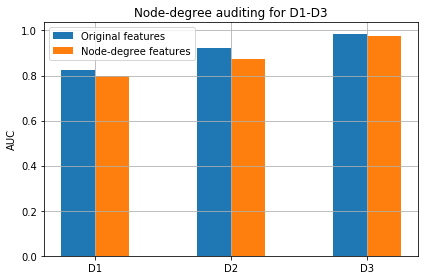

In [62]:
df4 = pd.read_csv('./DataForJupyters/NodeDegreeAuditorResults.csv')

# Setting up figures 
fig, axs = plt.subplots()
x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars
labels = ['D1', 'D2', 'D3']

BestOriginal = df4.Best
NodeLearning = df4.Node
rects1 = axs.bar(x - (width/2), BestOriginal, width, label='Original features')
rects2 = axs.bar(x + (width/2), NodeLearning, width, label='Node-degree features')

axs.set_ylabel('AUC')
axs.set_title('Node-degree auditing for D1-D3')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()



For all datasets, training an arbitrary model on the node-degree features is not significantly different from the corresponding performance when the frameworks are trained on the non-manipulated features. This strongly suggests that what all frameworks learn is the recurrence of each protein in the dataset rather than extracting useful information from protein features. This can explain why the predictors fail to generalize to out-of-network protein pairs, as they do not exist in the training data. 

## [STEP 5]: *Recurrence Auditor*
We next want to investigate how protein node-degrees contribute to the prediction decision, especially that there are two proteins in each example and each can be highly or lowly represented in the positive or the negative training data. 

For that, we designed the *Recurrence Auditor* where the auxiliary model is a simple scoring function that uses differential node degrees between the positive and negative training examples as the sole information to estimate the probability of interactions for new protein pairs. For example, for a pair (A,B), if NodeDegree(A|positive) = 5, NodeDegree(B|positive) = 10, NodeDegree(A|negative) = 20, and NodeDegree(B|negative) = 2, the probability that A and B interact according to that scoring function = (5+10)/(5+10+20+2) = 0.4054. The main model is the best across F1-F7 for each dataset as in the *Node-degree Auditor*. If the performance of the main and auxiliary models are not significantly different, then the frameworks are highly likely to be learning to predict protein pairs based on this differential node degree information. 

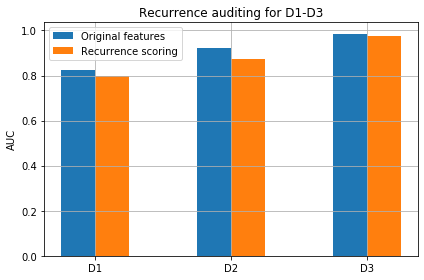

In [63]:
df5 = pd.read_csv('./DataForJupyters/RecurrenceAuditorResults.csv')

# Setting up figures 
fig, axs = plt.subplots()
x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars
labels = ['D1', 'D2', 'D3']

BestOriginal = df4.Best
NodeLearning = df4.Node
rects1 = axs.bar(x - (width/2), BestOriginal, width, label='Original features')
rects2 = axs.bar(x + (width/2), NodeLearning, width, label='Recurrence scoring')

axs.set_ylabel('AUC')
axs.set_title('Recurrence auditing for D1-D3')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


As there is no significant difference between the main and auxiliary models in the *Recurrence Auditor*, it is highly likely that the frameworks learn the same node-degree differential information as the scoring function does. 

## [STEP 6]: *Debiasing Auditor*
By now, we understand that differential recurrence of the proteins in the positive and negative training sets drive the frameworks to learn this difference. Let's look at the performance of the frameworks when the node-degree bias is removed. There can be many ways to remove that bias, for example, altering framework designs to account for that bias. The way we chose to remove that node degree bias is by changing the structure of the input network such that each protein appears equally in the positive and negative training networks. This should not affect the learning process as the frameworks are designed to learn from the features not the node degrees or abundance of proteins in one class versus the other. 

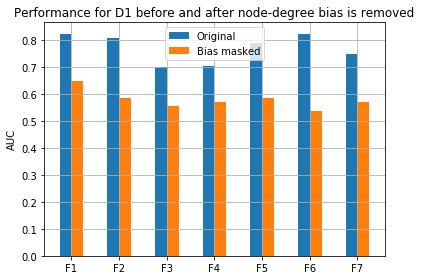

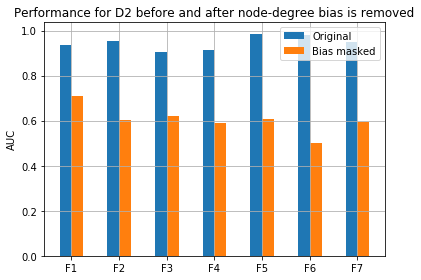

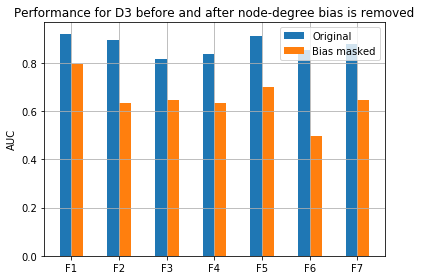

In [76]:
df6 = pd.read_csv('./DataForJupyters/DebiasingResults_Symm.csv')

# Setting up figures 
x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars
labels = ['F1', 'F2', 'F3', 'F4', 'F5','F6','F7']

# Marcotte dataset
fig, axs = plt.subplots()
D1org = df6.D1org
D1deb = df6.D1deb
rects1 = axs.bar(x - (width/2), D1org, width, label='Original')
rects2 = axs.bar(x + (width/2), D1deb, width, label='Bias masked')

axs.set_ylabel('AUC')
axs.set_title('Performance for D1 before and after node-degree bias is removed')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Pan dataset
fig, axs = plt.subplots()
D2org = df6.D2org
D2deb = df6.D2deb
rects1 = axs.bar(x - (width/2), D2org, width, label='Original')
rects2 = axs.bar(x + (width/2), D2deb, width, label='Bias masked')

axs.set_ylabel('AUC')
axs.set_title('Performance for D2 before and after node-degree bias is removed')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Vidal dataset
fig, axs = plt.subplots()
D3org = df6.D3org
D3deb = df6.D3deb
rects1 = axs.bar(x - (width/2), D3org, width, label='Original')
rects2 = axs.bar(x + (width/2), D3deb, width, label='Bias masked')

axs.set_ylabel('AUC')
axs.set_title('Performance for D3 before and after node-degree bias is removed')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()

After removing the node-degree biases in training data, the model performances dropped significantly, which supports the hypothesis about the role node-degree bias plays in driving the learning of these frameworks, probably in absence of informative features. 

Now, we want to make sure that node-degree bias is the only major source of bias. To do this, we devised the *Debiasing Auditor* where both the features and the node-degree bias are masked. If the node-degree bias is the sole major bias, then the auxiliary models should perform randomly. 

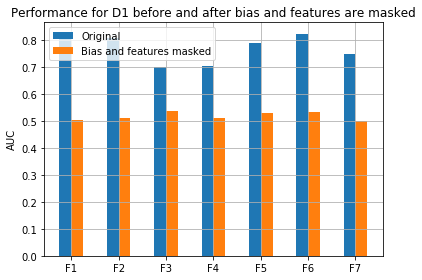

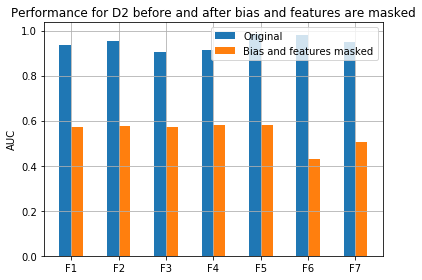

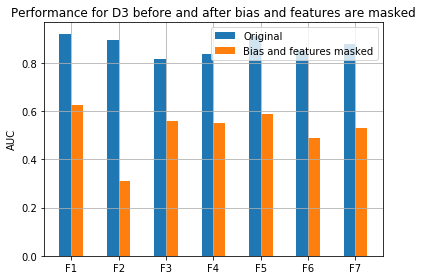

In [77]:
df7 = pd.read_csv('./DataForJupyters/DebiasingAuditorResults_Symm.csv')

# Setting up figures 
x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars
labels = ['F1', 'F2', 'F3', 'F4', 'F5','F6','F7']

# Marcotte dataset
fig, axs = plt.subplots()
D1org = df7.D1org
D1rnd = df7.D1deb
rects1 = axs.bar(x - (width/2), D1org, width, label='Original')
rects2 = axs.bar(x + (width/2), D1rnd, width, label='Bias and features masked')
axs.set_ylabel('AUC')
axs.set_title('Performance for D1 before and after bias and features are masked')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Pan dataset
fig, axs = plt.subplots()
D2org = df7.D2org
D2rnd = df7.D2deb
rects1 = axs.bar(x - (width/2), D2org, width, label='Original')
rects2 = axs.bar(x + (width/2), D2rnd, width, label='Bias and features masked')
axs.set_ylabel('AUC')
axs.set_title('Performance for D2 before and after bias and features are masked')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Vidal dataset
fig, axs = plt.subplots()
D3org = df7.D3org
D3rnd = df7.D3deb
rects1 = axs.bar(x - (width/2), D3org, width, label='Original')
rects2 = axs.bar(x + (width/2), D3rnd, width, label='Bias and features masked')
axs.set_ylabel('AUC')
axs.set_title('Performance for D3 before and after bias and features are masked')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()



Generally, after removing the node-degree biases from the training data, the model performances are efficiently randomized, which confirms the role of node-degree bias in driving these frameworks original (benchmarking) performances. 

## [STEP 7]: Generalizability Auditor II 
Now, let's see what is the real generalization performance after bias is removed. 

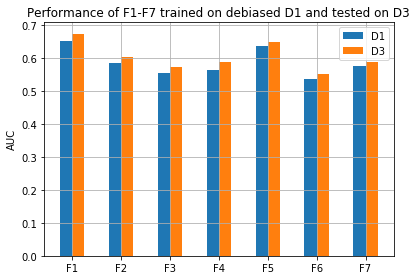

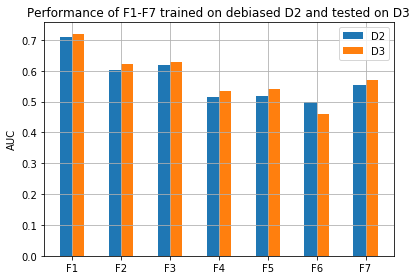

In [78]:
df8 = pd.read_csv('./DataForJupyters/GeneralizabilityAuditorIIResults.csv')

# Setting up figures 
x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars
labels = ['F1', 'F2', 'F3', 'F4', 'F5','F6','F7']

# Marcotte dataset
fig, axs = plt.subplots()
D1deb = df8.D1deb
D1gen = df8.D1gen
rects1 = axs.bar(x - (width/2), D1deb, width, label='D1')
rects2 = axs.bar(x + (width/2), D1gen, width, label='D3')
axs.set_ylabel('AUC')
axs.set_title('Performance of F1-F7 trained on debiased D1 and tested on D3')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()


# Pan dataset
fig, axs = plt.subplots()
D2deb = df8.D2deb
D2gen = df8.D2gen
rects1 = axs.bar(x - (width/2), D2deb, width, label='D2')
rects2 = axs.bar(x + (width/2), D2gen, width, label='D3')
axs.set_ylabel('AUC')
axs.set_title('Performance of F1-F7 trained on debiased D2 and tested on D3')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.legend()
axs.grid(True)
fig.tight_layout()
plt.show()

After debiasing, The gap between the benchmarking and generalization performances is insignificant, which indicates that the bias driving thee frameworks is now removed. 

## Conclusions 
We have demonstrated that node-degree bias in training networks drive the learning of paired-input PPI predictors and prevent them from generalizing to out-of-network predictions. However, when the identified bias is removed, the performance dropped. Examining these predictors, we found that they all extract global summarizing information to represent each protein features while interactions can be sensitive to a few amino acid substituations and location of the binding sequences, which would get lost in global summarizations. This shows how the common practice in the PPI prediction domain where proteins are represented by some summary information is driving the field prediction frameworks to be biased. To tackle this problem, better features that pay attention to localized signals need to be designed. 